<a href="https://colab.research.google.com/github/tfindiamooc/tfindiamooc.github.io/blob/master/colabs/tf_customization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Customization

So far in this course, we used methods provided by build in TF APIs like tf.Keras and tf.Estimator.  While these constructs are sufficient to start any AI project, there could be situations where you may have to implement custom models, loss functions or metrics.  Tensorflow 2.0 provides support for extending its functionality.  In this module, we will learn how to customize TF 2.0 functionality.

In [0]:
#@title Import TF 2.0

from __future__ import absolute_import, division, print_function

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


## Part 1: Tensors and Accelerators

### Tensors

A Tensor is a multi-dimensional array. Similar to NumPy `ndarray` objects, `tf.Tensor` objects have a **data type** and a **shape**. Additionally, `tf.Tensor`s can *reside in accelerator memory (like a GPU)*. TensorFlow offers a rich library of operations ([tf.add](https://www.tensorflow.org/api_docs/python/tf/add), [tf.matmul](https://www.tensorflow.org/api_docs/python/tf/matmul), [tf.linalg.inv](https://www.tensorflow.org/api_docs/python/tf/linalg/inv) etc.) that consume and produce `tf.Tensor`s. These operations automatically convert native Python types, for example:


In [0]:
# We can add two scalars
print(tf.add(1, 2))   
# returns tf.Tensor(3, shape=(), dtype=int32)

# or add vectors
print(tf.add([1, 2], [3, 4]))  
# returns tf.Tensor([4 6], shape=(2,), dtype=int32)

# square the number 
print(tf.square(5))
# returns tf.Tensor(25, shape=(), dtype=int32)

# sum the elements in the list and return a scalar, which is sum of elements 
# in the list
print(tf.reduce_sum([1, 2, 3]))  # 1 + 2 + 3
# returns tf.Tensor(6, shape=(), dtype=int32) 

# Operator overloading is also supported
print(tf.square(2) + tf.square(3))

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor([4 6], shape=(2,), dtype=int32)
tf.Tensor(25, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(13, shape=(), dtype=int32)


Recall that each tf.Tensor has a shape and a datatype:

In [0]:
x = tf.matmul([[1]], [[2, 3]])
print(x)
print("Shape: %s"%x.shape)
print("Data type: %s"%x.dtype)

tf.Tensor([[2 3]], shape=(1, 2), dtype=int32)
Shape: (1, 2)
Data type: <dtype: 'int32'>


The most obvious differences between NumPy arrays and `tf.Tensor`s are:

1. Tensors can be backed by accelerator memory (like GPU, TPU).
2. Tensors are immutable.

### NumPy Compatibility

Converting between a TensorFlow `tf.Tensor`s and a NumPy `ndarray` is easy:

* TensorFlow operations automatically convert NumPy ndarrays to Tensors.
* NumPy operations automatically convert Tensors to NumPy ndarrays.

Tensors are explicitly converted to NumPy ndarrays using their `.numpy()` method. These conversions are typically cheap since the array and `tf.Tensor` share the underlying memory representation, if possible. However, sharing the underlying representation isn't always possible since the `tf.Tensor` may be hosted in GPU memory while NumPy arrays are always backed by host memory, and the conversion involves a copy from GPU to host memory.

In [0]:
import numpy as np

ndarray = np.ones([3, 3])
print ("Content of array:")
print (ndarray)
print ()

print("TensorFlow operations convert numpy arrays to Tensors automatically")
tensor = tf.multiply(ndarray, 42)
print(tensor)
print ()

print("And NumPy operations convert Tensors to numpy arrays automatically")
print(np.add(tensor, 1))
print ()

print("The .numpy() method explicitly converts a Tensor to a numpy array")
print(tensor.numpy())
print ()

Content of array:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]

TensorFlow operations convert numpy arrays to Tensors automatically
tf.Tensor(
[[42. 42. 42.]
 [42. 42. 42.]
 [42. 42. 42.]], shape=(3, 3), dtype=float64)

And NumPy operations convert Tensors to numpy arrays automatically
[[43. 43. 43.]
 [43. 43. 43.]
 [43. 43. 43.]]

The .numpy() method explicitly converts a Tensor to a numpy array
[[42. 42. 42.]
 [42. 42. 42.]
 [42. 42. 42.]]



### GPU acceleration

Many TensorFlow operations are accelerated using the GPU for computation. Without any annotations, TensorFlow automatically decides whether to use the GPU or CPU for an operation—copying the tensor between CPU and GPU memory, if necessary. Tensors produced by an operation are typically backed by the memory of the device on which the operation executed, for example:

In [0]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

Is there a GPU available: 
True


Check if the tensor is stored in GPU with `tensor.device.endswith` method.

In [0]:
print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

Is the Tensor on GPU #0:  
True


### How does it specify device names?

The `Tensor.device` property provides a fully qualified string name of the device hosting the contents of the tensor. This name encodes many details, such as (i) an **identifier of the network address** of the host on which this program is executing and (ii) the **device within that host**. This is required for distributed execution of a TensorFlow program. The string ends with `GPU:<N>` if the tensor is placed on the `N`-th GPU on the host.

### How can we place a tensor on GPU explicitely?

In TensorFlow, *placement* refers to how individual operations are assigned (placed on) a device for execution. As mentioned, when there is no explicit guidance provided, TensorFlow automatically decides which device to execute an operation and copies tensors to that device, if needed. However, TensorFlow operations can be explicitly placed on specific devices using the `tf.device` context manager, for example:

In [0]:
## We will perform matrix multiplication on CPU and GPU and compare the timings.

import time

# Function for matrix multiplication with itself 10 times.
def time_matmul(x):
  start = time.time()
  
  # Perform multiplication 100 times.
  for loop in range(100):
    tf.matmul(x, x)

  result = time.time()-start

  print("100 loops: {:0.2f}ms".format(1000*result))

# Force execution on CPU 
print("On CPU:")
with tf.device("CPU:0"):
  x = tf.random.uniform([1000, 1000])
  assert x.device.endswith("CPU:0")
  time_matmul(x)

print()

# Force execution on GPU #0 if available by first placing the tensor on GPU.
if tf.test.is_gpu_available():
  print("On GPU:")
  with tf.device("GPU:0"): # Or GPU:1 for the 2nd GPU, GPU:2 for the 3rd etc.
    x = tf.random.uniform([1000, 1000])
    assert x.device.endswith("GPU:0")
    time_matmul(x)

On CPU:
100 loops: 2690.45ms

On GPU:
100 loops: 4.02ms


## Part 2: Customize tf.Keras Sequential API

Customization opportunities:
* Model
* Loss function
* Training Loop
* Metrics

Let's learn how we can carry out these customizations in this section.

### Writing custom layers

Layers provide higher level of abstraction for implementing ML models. Many machine learning models are expressible as the composition and stacking of relatively simple layers, and TensorFlow provides both a set of many common layers as a well as easy ways for you to write your own application-specific layers either from scratch or as the composition of existing layers.

In [0]:
# In the tf.keras.layers package, layers are objects. To construct a layer,
# simply construct the object. Most layers take as a first argument the number
# of output dimensions / channels.
layer = tf.keras.layers.Dense(100)

# The number of input dimensions is often unnecessary, as it can be inferred
# the first time the layer is used, but it can be provided if you want to
# specify it manually, which is useful in some complex models.
layer = tf.keras.layers.Dense(10, input_shape=(None, 5))

Example layers are Dense (a fully-connected layer),
Conv2D, LSTM, BatchNormalization, Dropout, and many others.  The full list can be found in [the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers). 

In [0]:
# To use a layer, simply call it.
layer(tf.zeros([10, 5]))

<tf.Tensor: id=712, shape=(10, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [0]:
# Layers have many useful methods. For example, you can inspect all variables
# in a layer using `layer.variables` and trainable variables using
# `layer.trainable_variables`. In this case a fully-connected layer
# will have variables for weights and biases.
layer.variables

[<tf.Variable 'dense_1/kernel:0' shape=(5, 10) dtype=float32, numpy=
 array([[-0.10956973, -0.32350817,  0.33780086, -0.355431  , -0.595714  ,
         -0.3596113 , -0.19393778, -0.04922861,  0.22064978, -0.2343215 ],
        [-0.06548589, -0.14383852, -0.146968  ,  0.36432648, -0.49617139,
         -0.22814971,  0.11680913, -0.54332936,  0.12799722,  0.53414744],
        [-0.33322757,  0.31441182, -0.5343494 ,  0.4118405 ,  0.44340605,
          0.46069974, -0.23017013, -0.17695966, -0.4530635 , -0.49714383],
        [-0.30850297, -0.14670593,  0.3785556 , -0.03918439,  0.43342572,
          0.12621808,  0.5813835 , -0.22612536, -0.43294474, -0.54165995],
        [ 0.29879034,  0.01249349, -0.5123859 , -0.06109631,  0.14176685,
         -0.14670292, -0.23124829,  0.4585678 ,  0.6174125 , -0.52170664]],
       dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]

In [0]:
# The variables are also accessible through nice accessors
layer.kernel, layer.bias

(<tf.Variable 'dense_1/kernel:0' shape=(5, 10) dtype=float32, numpy=
 array([[-0.10956973, -0.32350817,  0.33780086, -0.355431  , -0.595714  ,
         -0.3596113 , -0.19393778, -0.04922861,  0.22064978, -0.2343215 ],
        [-0.06548589, -0.14383852, -0.146968  ,  0.36432648, -0.49617139,
         -0.22814971,  0.11680913, -0.54332936,  0.12799722,  0.53414744],
        [-0.33322757,  0.31441182, -0.5343494 ,  0.4118405 ,  0.44340605,
          0.46069974, -0.23017013, -0.17695966, -0.4530635 , -0.49714383],
        [-0.30850297, -0.14670593,  0.3785556 , -0.03918439,  0.43342572,
          0.12621808,  0.5813835 , -0.22612536, -0.43294474, -0.54165995],
        [ 0.29879034,  0.01249349, -0.5123859 , -0.06109631,  0.14176685,
         -0.14670292, -0.23124829,  0.4585678 ,  0.6174125 , -0.52170664]],
       dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>)

### Implementing custom layers
The best way to implement your own layer is extending the tf.keras.Layer class and implementing:
  *  `__init__` , where you can do all input-independent initialization
  * `build`, where you know the shapes of the input tensors and can do the rest of the initialization
  * `call`, where you do the forward computation

Note that you don't have to wait until `build` is called to create your variables, you can also create them in `__init__`. However, 
* The advantage of creating them in `build` is that it enables **late variable creation** based on the shape of the inputs the layer will operate on. 
* On the other hand, creating variables in `__init__` would mean that **shapes required to create the variables will need to be explicitly specified**.

In [0]:
class MyDenseLayer(tf.keras.layers.Layer):
  def __init__(self, num_outputs):
    super(MyDenseLayer, self).__init__()
    self.num_outputs = num_outputs

  def build(self, input_shape):
    self.kernel = self.add_weight("kernel",
                                    shape=[int(input_shape[-1]),
                                           self.num_outputs])

  def call(self, input):
    return tf.matmul(input, self.kernel)

layer = MyDenseLayer(10)
print(layer(tf.zeros([10, 5])))
print(layer.trainable_variables)

tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)
[<tf.Variable 'my_dense_layer_3/kernel:0' shape=(5, 10) dtype=float32, numpy=
array([[-0.31258893,  0.38091224,  0.41181916, -0.61967224,  0.17612201,
         0.06819528,  0.15260917,  0.38091964,  0.3039915 ,  0.2989155 ],
       [ 0.47723454,  0.3802932 , -0.14199075,  0.5533703 ,  0.03621048,
         0.17587095, -0.3106733 , -0.21331221,  0.33207327, -0.3939585 ],
       [ 0.33359325,  0.5275132 ,  0.16026789, -0.11183548,  0.39218384,
        -0.3064334 , -0.22519907,  0.10764974, -0.56869465,  0.5773694 ],
       [-0.5526781 ,  0.10882616,  0.10456622, -0.27670157, -0.06649667,
         0.07259607,  0.28208548, 

## Part 3: Automatic Differentiation

Automatic differentiation is a key technique for optimizing ML models.



### Gradient tapes

TensorFlow provides the [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) API for automatic differentiation - computing the gradient of a computation with respect to its input variables. 
* Tensorflow "records" all operations executed inside the context of a `tf.GradientTape` onto a "tape". 
* Tensorflow then uses that tape and the gradients associated with each recorded operation to compute the gradients of a "recorded" computation using [reverse mode differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). 

For each example shown here, we will construct a computation graph and work out the derivatives.  We compare the manually calculated derivatives with automatic differentiation. 

Any computation wrapped in a tape is recorded, and after the operations have happened you can request gradients from any Tensor to any variable:

In [0]:
x = tf.Variable(1.0)
with tf.GradientTape() as tape:
  y = x ** 2
  z = y ** 2
dz_dx, dz_dy = tape.gradient(z, [x, y])
print(dz_dx.numpy())  # 4.0
print(dz_dy.numpy())  # 2.0

4.0
2.0


If you want to request a gradient from a tensor to another tensor, then you need to tell the tape to watch the source tensor:

In [0]:
x = tf.constant(1.0)
with tf.GradientTape() as tape:
  tape.watch(x)  # Since `x` is not a variable we must explicitly "watch" it.
  y = x ** 2
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())  # 2.0

2.0


By default, the resources held by a GradientTape are released as soon as GradientTape.gradient() method is called. To compute multiple gradients over the same computation, create a `persistent` gradient tape. This allows multiple calls to the `gradient()` method as resources are released when the tape object is garbage collected. For example:

In [0]:
x = tf.constant(3.0)
with tf.GradientTape(persistent=True) as t:
  t.watch(x)
  y = x * x
  z = y * y
dz_dx = t.gradient(z, x)  # 108.0 (4*x^3 at x = 3)
dy_dx = t.gradient(y, x)  # 6.0

print (dy_dx)
print (dz_dy)
print (dz_dx)

del t  # Drop the reference to the tape

tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(108.0, shape=(), dtype=float32)


### Recording control flow

Because tapes record operations as they are executed, Python control flow (using `if`s and `while`s for example) is naturally handled:

In [0]:
def f(x, y):
  output = 1.0
  for i in range(y):
    if i > 1 and i < 5:
      output = tf.multiply(output, x)
  return output

def grad(x, y):
  with tf.GradientTape() as t:
    t.watch(x)
    out = f(x, y)
  return t.gradient(out, x)

x = tf.convert_to_tensor(2.0)

assert grad(x, 6).numpy() == 12.0
assert grad(x, 5).numpy() == 12.0
assert grad(x, 4).numpy() == 4.0

### Higher-order gradients

Operations inside of the `GradientTape` context manager are recorded for automatic differentiation. If gradients are computed in that context, then the gradient computation is recorded as well. As a result, the exact same API works for higher-order gradients as well. For example:

In [0]:
x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0

with tf.GradientTape() as t:
  with tf.GradientTape() as t2:
    y = x * x * x
  # Compute the gradient inside the 't' context manager
  # which means the gradient computation is differentiable as well.
  dy_dx = t2.gradient(y, x)
d2y_dx2 = t.gradient(dy_dx, x)

assert dy_dx.numpy() == 3.0
assert d2y_dx2.numpy() == 6.0

In this section, we covered gradient computation in TensorFlow. With that we have enough of the primitives required to build and train neural networks.

## Part 4: Custom Training

Let's train neural networks from the first principle so as to acquire strong foundational understanding of the concepts.  We use `tf.Variable` to represent weights in a model.  A `tf.Variable` object stores a value and implicitly reads from this stored value. There are operations (`tf.assign_sub`, `tf.scatter_update`, etc.) that manipulate the value stored in a TensorFlow variable.



In [0]:
v = tf.Variable(1.0)
# Use Python's `assert` as a debugging statement to test the condition
assert v.numpy() == 1.0

# Reassign the value `v`
v.assign(3.0)
assert v.numpy() == 3.0

# Use `v` in a TensorFlow `tf.square()` operation and reassign
v.assign(tf.square(v))
assert v.numpy() == 9.0

### Fit a linear model

Let's use the concepts you have learned so far—`Tensor`, `Variable`, and `GradientTape`—to build and train a simple model. This typically involves a few steps:

1. Define the model.
2. Define a loss function.
3. Obtain training data.
4. Run through the training data and use an "optimizer" to adjust the variables to fit the data.

Here, you'll create a simple linear model, `f(x) = x * W + b`, which has two variables: `W` (weights) and `b` (bias). You'll synthesize data such that a well trained model would have `W = 3.0` and `b = 2.0`.

### Define the model

Let's define a simple class to encapsulate the variables and the computation:

In [0]:
class Model(object):
  def __init__(self):
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be initialized to random values (for example, with `tf.random.normal`)
    self.W = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.W * x + self.b

model = Model()

assert model(3.0).numpy() == 15.0

### Define a loss function

A loss function measures how well the output of a model for a given input matches the target output. The goal is to minimize this difference during training. Let's use the standard L2 loss, also known as the least square errors:

In [0]:
def loss(predicted_y, target_y):
  return tf.reduce_mean(tf.square(predicted_y - target_y))

### Obtain training data

First, synthesize the training data by adding random Gaussian (Normal) noise to the inputs:

In [0]:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
noise   = tf.random.normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

Before training the model, visualize the loss value by plotting the model's predictions in red and the training data in blue:

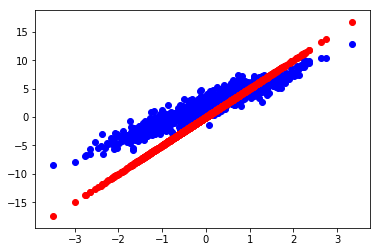

Current loss: 9.094963


In [0]:
import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: %1.6f' % loss(model(inputs), outputs).numpy())

### Define a training loop

With the network and training data, train the model using [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) to update the weights variable (`W`) and the bias variable (`b`) to reduce the loss. There are many variants of the gradient descent scheme that are captured in `tf.train.Optimizer`—our recommended implementation. But in the spirit of building from first principles, here you will implement the basic math yourself with the help of `tf.GradientTape` for automatic differentiation and `tf.assign_sub` for decrementing a value (which combines `tf.assign` and `tf.sub`):

In [0]:
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
  dW, db = t.gradient(current_loss, [model.W, model.b])
  model.W.assign_sub(learning_rate * dW)
  model.b.assign_sub(learning_rate * db)

Finally, let's repeatedly run through the training data and see how W and b evolve.

Epoch  0: W=5.00 b=0.00, loss=9.09496
Epoch  1: W=4.59 b=0.41, loss=6.10919
Epoch  2: W=4.27 b=0.73, loss=4.21764
Epoch  3: W=4.01 b=0.99, loss=3.01930
Epoch  4: W=3.80 b=1.20, loss=2.26011
Epoch  5: W=3.64 b=1.36, loss=1.77912
Epoch  6: W=3.51 b=1.49, loss=1.47439
Epoch  7: W=3.40 b=1.59, loss=1.28133
Epoch  8: W=3.32 b=1.67, loss=1.15900
Epoch  9: W=3.25 b=1.74, loss=1.08150


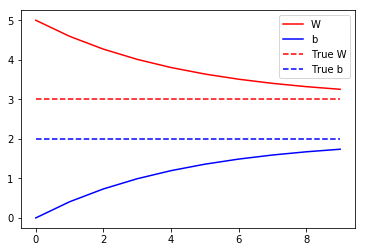

In [0]:
model = Model()

# Collect the history of W-values and b-values to plot later
Ws, bs = [], []
epochs = range(10)
for epoch in epochs:
  Ws.append(model.W.numpy())
  bs.append(model.b.numpy())
  current_loss = loss(model(inputs), outputs)

  train(model, inputs, outputs, learning_rate=0.1)
  print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, Ws[-1], bs[-1], current_loss))

# Let's plot it all
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'True W', 'True b'])
plt.show()


## Homework

Run [IRIS flower classification](https://www.tensorflow.org/beta/tutorials/eager/custom_training_walkthrough) colab notebook for end-to-end ML process understanding.